In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)


In [3]:
#1. Check for GPU
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device:{device}")

Using device:cuda


In [4]:
df = pd.read_csv('/content/fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df.shape

(60000, 785)

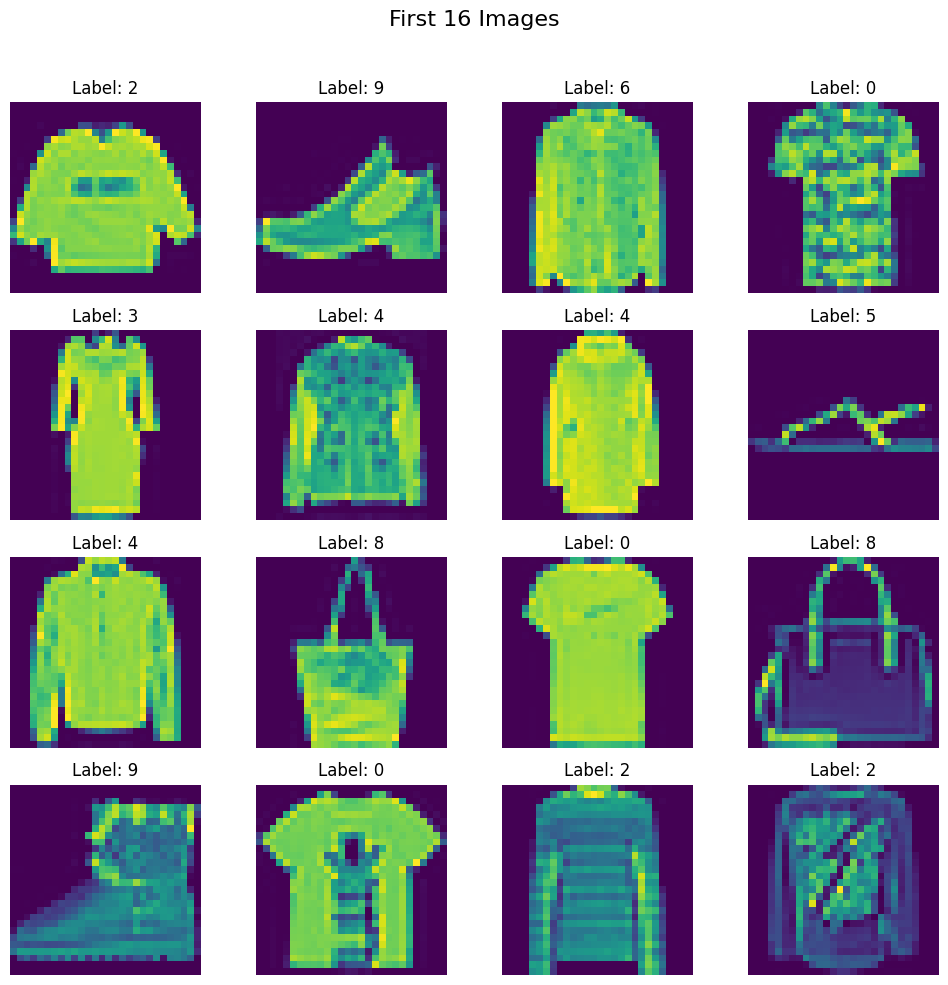

In [6]:
# Create a 4x4 grid of images

fig,axes = plt.subplots(4,4,figsize = (10,10))
fig.suptitle("First 16 Images", fontsize = 16)

# PLot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
  img = df.iloc[i,1:].values.reshape(28,28) # Reshape to 28x28
  ax.imshow(img)  # Display in grayScale
  ax.axis("off")  # Remove axis for a cleaner look
  ax.set_title(f"Label: {df.iloc[i,0]}") # SHow the look

plt.tight_layout(rect=[0,0,1,0.96])  # Adjust layout to fit the titile

plt.show()

In [7]:
# Train test split
X = df.iloc[:,1:].values
y = df.iloc[:,0].values

In [8]:
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size=0.2,random_state=42)

In [9]:
## Scaling the featurees
X_train = X_train/255.0
X_test = X_test/255.0

In [10]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00392157, 0.        ,
        0.        ]])

In [11]:
# Create a CustomDataset Class

class CustomDataset(Dataset):

  def __init__(self, features, labels):
    # Convert to PyTorch tensors
    self.features = torch.tensor(features,dtype = torch.float32)
    self.labels =  torch.tensor(labels,dtype = torch.long)

  def __len__(self):

    return len(self.features)

  def __getitem__(self,index):
    return self.features[index], self.labels[index]


In [12]:
## Create Train_datasets object

train_dataset = CustomDataset(X_train,y_train)

In [13]:
len(train_dataset)

48000

In [14]:
## Create Test_datasets object

test_dataset = CustomDataset(X_test,y_test)

In [15]:
len(test_dataset)

12000

In [16]:
# # Create Train and Test Loader
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size = 32, shuffle= False)

In [17]:
# len(train_loader)

In [33]:
class MyNN(nn.Module):

  def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):

    super().__init__()

    layers = []

    for i in range(num_hidden_layers):

      layers.append(nn.Linear(input_dim, neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout_rate))
      input_dim = neurons_per_layer

    layers.append(nn.Linear(neurons_per_layer, output_dim))

    self.model = nn.Sequential(*layers)

  def forward(self, x):

    return self.model(x)

## Hyperparameter Tuning the ANN using Optuna

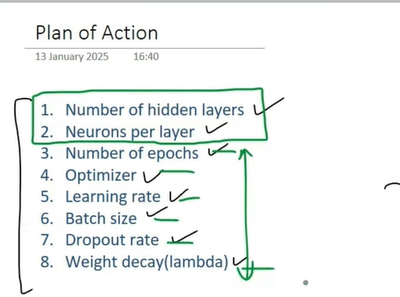

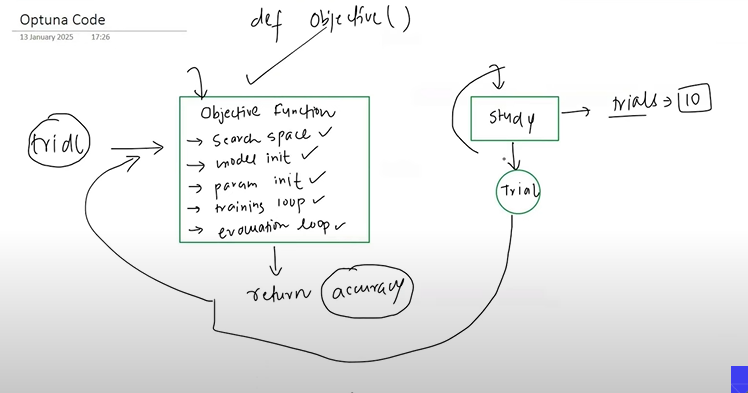

In [35]:
# objective function
def objective(trial):

  # next hyperparameter values from the search space
  num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
  neurons_per_layer = trial.suggest_int("neurons_per_layer", 8, 128, step=8)
  epochs = trial.suggest_int("epochs", 10, 50, step=10)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
  batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128])
  optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
  weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-3, log=True)

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

  # model init
  input_dim = 784
  output_dim = 10

  model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
  model.to(device)

  # optimizer selection
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-4)

  if optimizer_name == 'Adam':
    optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  elif optimizer_name == 'SGD':
    optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
  else:
    optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  # training loop

  for epoch in range(epochs):

    for batch_features, batch_labels in train_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      # forward pass
      outputs = model(batch_features)

      # calculate loss
      loss = criterion(outputs, batch_labels)

      # back pass
      optimizer.zero_grad()
      loss.backward()

      # update grads
      optimizer.step()


  # evaluation
  model.eval()
  # evaluation on test data
  total = 0
  correct = 0

  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [36]:
!pip install optuna

In [37]:
import optuna

study = optuna.create_study(direction='maximize')

[I 2025-03-01 16:46:38,552] A new study created in memory with name: no-name-5c20a704-8c1d-491a-abd2-8b12adc44350


In [38]:


study.optimize(objective, n_trials=10)

[I 2025-03-01 16:47:22,941] Trial 0 finished with value: 0.8851666666666667 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 112, 'epochs': 20, 'learning_rate': 0.0016213706023672583, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer': 'SGD', 'weight_decay': 9.976759496136789e-05}. Best is trial 0 with value: 0.8851666666666667.
[I 2025-03-01 16:49:35,207] Trial 1 finished with value: 0.8826666666666667 and parameters: {'num_hidden_layers': 4, 'neurons_per_layer': 72, 'epochs': 50, 'learning_rate': 0.0012656685214674519, 'dropout_rate': 0.30000000000000004, 'batch_size': 64, 'optimizer': 'SGD', 'weight_decay': 3.0099615166449133e-05}. Best is trial 0 with value: 0.8851666666666667.
[I 2025-03-01 16:50:21,591] Trial 2 finished with value: 0.8839166666666667 and parameters: {'num_hidden_layers': 1, 'neurons_per_layer': 128, 'epochs': 30, 'learning_rate': 0.000943361735111962, 'dropout_rate': 0.2, 'batch_size': 64, 'optimizer': 'SGD', 'weight_decay': 1.300416469207773e-05}. B

In [39]:
study.best_value

0.8851666666666667

In [40]:
study.best_params

{'num_hidden_layers': 1,
 'neurons_per_layer': 112,
 'epochs': 20,
 'learning_rate': 0.0016213706023672583,
 'dropout_rate': 0.2,
 'batch_size': 64,
 'optimizer': 'SGD',
 'weight_decay': 9.976759496136789e-05}

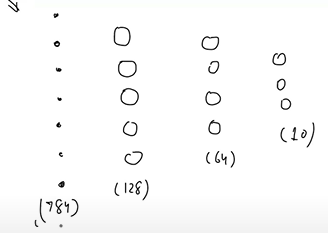